# 22-data-exploration-seasonality
> Exploratory data analysis on seasonality, which solves issues 12 & 13

The purpose of this notebook series is to perform any desired exploration of the data.

General Findings:

Seasons data is a bit skewed as we don’t have enough Spring information.  We don’t have enough spring information as our data started on 6/28/21, which is Summer. For some graphics, we also need to be aware that winter goes from 12/21-3/19, so grouping seasons data with year may cause some slight distortion on first glance as we do not have even further historical data.

The team must discuss if there is actually viable from having the large skewness in data provided.
Generally, we see autumn to have higher number of phone claims across the board, but it could possibly be because of more datapoints.

There is also a skewness in the quarterly data as our data started at the very last week of Q2 2021 and we have incomplete information on Q1 2023. This skewness has impacted our claims values. There is a potential increasing trend in phone claims data from prior quarterly years, but we’re unable to tell due to lack of historical data. We could possibly infer that Q3 & Q4 will have more Apple claims then Q1 and Q2 as seen when evaluating 2022.
Holidays don’t seem to make any impact.

#### Helpful packages and preliminaries

In [1]:
#Data processing and evaluation
import pandas as pd
import numpy as np

#Graphical display
import matplotlib.pyplot as plt
import seaborn as sns

#Graphing magics
%matplotlib inline

from datetime import date, datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import os

In [2]:
#Constants/globals
os.chdir('/data/p_dsi/teams2023/team9/')
os.getcwd()

'/gpfs52/data/p_dsi/teams2023/team9'

## Assessment and visualization

In [3]:
#load and view data
data = pd.read_csv("Asurion_clean_data.csv")
data.head(10)

,phone model,phone size,phone color,claim,weeks_monday
0,alcatel axel,32gb,black,1,2022-01-24
1,alcatel axel,32gb,black,3,2022-11-14
2,alcatel axel,32gb,black,1,2022-11-21
3,alcatel axel,32gb,black,3,2022-11-28
4,alcatel axel,32gb,black,1,2022-12-12
5,alcatel smartflip 4052r,4gb,black,1,2022-07-04
6,alcatel smartflip 4052r,4gb,black,1,2022-07-25
7,alcatel smartflip 4052r,4gb,black,3,2022-08-01
8,alcatel smartflip 4052r,4gb,black,1,2022-08-08
9,alcatel smartflip 4052r,4gb,black,1,2022-08-15


In [4]:
data_copy = data.copy()
# Adding in date_time_object, month, and year columns
# date_time_object is needed to create the other columns
data_copy['date_time_object'] = pd.to_datetime(data_copy['weeks_monday'])


# Note: Since we extract month from the first instance in the date_time_object to use it for our calcuations, we do not consider
# the situations where dates roll into the following year or following month within its 7 day period.
# This assumption will affect quarter labels due to the specific cut-off used on the month.
data_copy['month'] = data_copy['date_time_object'].dt.month
data_copy['year'] = data_copy['date_time_object'].dt.year

display(data_copy)

,phone model,phone size,phone color,claim,weeks_monday,date_time_object,month,year
0,alcatel axel,32gb,black,1,2022-01-24,2022-01-24,1,2022
1,alcatel axel,32gb,black,3,2022-11-14,2022-11-14,11,2022
2,alcatel axel,32gb,black,1,2022-11-21,2022-11-21,11,2022
3,alcatel axel,32gb,black,3,2022-11-28,2022-11-28,11,2022
4,alcatel axel,32gb,black,1,2022-12-12,2022-12-12,12,2022
...,...,...,...,...,...,...,...,...
26656,samsung galaxy z fold3 5g,256gb,silver,17,2023-01-30,2023-01-30,1,2023
26657,samsung galaxy z fold3 5g,256gb,silver,26,2023-02-06,2023-02-06,2,2023
26658,samsung galaxy z fold3 5g,256gb,silver,4,2023-02-13,2023-02-13,2,2023
26659,samsung galaxy z fold3 5g,512gb,black,61,2023-02-06,2023-02-06,2,2023


In [5]:
# The number of days in each season based on solstices & equinoxes in the northern hemisphere are the following:
# Winter - 88 days - 12/21 - 3/19
# Spring - 92 days - 3/20 - 6/20
# Summer - 93 days - 6/21 - 9/22
# Autumn - 88 days - 9/23 - 12/20
# Since data does not include leap year, the values above do not include leap year
seasons = [('winter', (date(2021,  1,  1),  date(2021,  3, 19))),
           ('spring', (date(2021,  3, 20),  date(2021,  6, 20))),
           ('summer', (date(2021,  6, 21),  date(2021,  9, 22))),
           ('autumn', (date(2021,  9, 23),  date(2021, 12, 20))),
           ('winter', (date(2021, 12, 21),  date(2021, 12, 31))),
           ('winter', (date(2022,  1,  1),  date(2022,  3, 19))),
           ('spring', (date(2022,  3, 20),  date(2022,  6, 20))),
           ('summer', (date(2022,  6, 21),  date(2022,  9, 22))),
           ('autumn', (date(2022,  9, 23),  date(2022, 12, 20))),
           ('winter', (date(2022, 12, 21),  date(2022, 12, 31))),
           ('winter', (date(2023,  1,  1),  date(2023,  3, 19))),
           ('spring', (date(2023,  3, 20),  date(2023,  6, 20))),
           ('summer', (date(2023,  6, 21),  date(2023,  9, 22))),
           ('autumn', (date(2023,  9, 23),  date(2023, 12, 20))),
           ('winter', (date(2023, 12, 21),  date(2023, 12, 31)))]


def get_season_asurion(now):
    if isinstance(now, datetime):
        now = now.date()
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

# Be careful to make sure that I don't override anything, function will impute "refresh datatable" if values are overridden
def get_month_asurion(month):
    if month == 1:
        return "January"
    elif month == 2:
        return "February"
    elif month == 3:
        return "March"
    elif month == 4:
        return "April"        
    elif month == 5:
        return "May"    
    elif month == 6:
        return "June"
    elif month == 7:
        return "July"
    elif month == 8:
        return "August"
    elif month == 9:
        return "September"
    elif month == 10:
        return "October"
    elif month == 11:
        return "November"
    elif month == 12:
        return "December"
    else:
        return "refresh datatable"

def get_quarter_asurion(month):
    if month == "January" or month == "February" or month == "March":
        return "Q1"
    elif month == "April" or month == "May" or month == "June":
        return "Q2"
    elif month == "July" or month == "August" or month == "September":
        return "Q3"
    else:
        return "Q4"

# Counts US Federal Holidays, includes the business day rule
# Function considers if holiday fell within that 7 day week range
# Note: We do not consider situation of people starting to travel on weekends because Monday is the actual holiday
cal = calendar()
def CountHolidayWeek(begin_date):
    holidays = cal.holidays(start = begin_date, end = begin_date + timedelta(days=6))
    if len(holidays) >= 1:
        return True
    else:
        return False


# Renaming month, labelling season, and quarter
data_copy['month'] = data_copy['month'].apply(get_month_asurion)
data_copy['season'] = data_copy['date_time_object'].apply(get_season_asurion)
data_copy['quarter'] = data_copy['month'].apply(get_quarter_asurion)

# Labelling Holidays_Boolean - True if holiday, false if not a holiday
unique_dates = data_copy.date_time_object.unique()
unique_dates_df = pd.DataFrame(unique_dates)

unique_dates_df["Holidays_Boolean"]= unique_dates_df[0].apply(CountHolidayWeek)
unique_dates_df.columns = ["date_time_object", "Holidays_Boolean"]

data_copy = pd.merge(data_copy, unique_dates_df, on = "date_time_object", how = "inner")
# Code to implement Holidays_Boolean is now complete

# Code to get company column
data_copy[['company', 'random']] = data_copy['phone model'].str.split(' ', 1, expand = True)
data_copy = data_copy.drop(['random'], axis=1)

display(data_copy)


,phone model,phone size,phone color,claim,weeks_monday,date_time_object,month,year,season,quarter,Holidays_Boolean,company
0,alcatel axel,32gb,black,1,2022-01-24,2022-01-24,January,2022,winter,Q1,False,alcatel
1,apple iphone 11,128gb,black,252,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple
2,apple iphone 11,128gb,green,45,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple
3,apple iphone 11,128gb,purple,92,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple
4,apple iphone 11,128gb,red,69,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple
...,...,...,...,...,...,...,...,...,...,...,...,...
26656,samsung galaxy z fold2 5g,256gb,bronze,2,2023-02-13,2023-02-13,February,2023,winter,Q1,False,samsung
26657,samsung galaxy z fold3 5g,256gb,black,69,2023-02-13,2023-02-13,February,2023,winter,Q1,False,samsung
26658,samsung galaxy z fold3 5g,256gb,green,18,2023-02-13,2023-02-13,February,2023,winter,Q1,False,samsung
26659,samsung galaxy z fold3 5g,256gb,silver,4,2023-02-13,2023-02-13,February,2023,winter,Q1,False,samsung


In [9]:
# This cell is to create the Asurion_clean_data_seasons_holidays.csv that is in our teams folder. 
# Make sure that the table is correct before exporting it to the dataset.
#data_copy_file = data_copy.copy()
#display(data_copy_file)
# Dropping the date_time_object column
#data_copy_file = data_copy_file.drop('date_time_object', axis = 1)
#display(data_copy_file)
#data_copy_file.to_csv('Asurion_clean_data_seasons_holidays.csv', index = False)

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company
0,alcatel axel,32gb,black,1,2022-01-24,January,2022,winter,Q1,False,alcatel
1,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple
2,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple
3,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple
4,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple
...,...,...,...,...,...,...,...,...,...,...,...
26656,samsung galaxy z fold2 5g,256gb,bronze,2,2023-02-13,February,2023,winter,Q1,False,samsung
26657,samsung galaxy z fold3 5g,256gb,black,69,2023-02-13,February,2023,winter,Q1,False,samsung
26658,samsung galaxy z fold3 5g,256gb,green,18,2023-02-13,February,2023,winter,Q1,False,samsung
26659,samsung galaxy z fold3 5g,256gb,silver,4,2023-02-13,February,2023,winter,Q1,False,samsung


# EDA Section
#### Section Covers Seasons, Quater, and Holidays

In [17]:
# Section for initialize section
data_copy_2 = data_copy.copy()

# Subset data to be on Apple only
apple = data_copy_2[data_copy_2["company"] == "apple"]

display(apple.head(5))

,phone model,phone size,phone color,claim,weeks_monday,date_time_object,month,year,season,quarter,Holidays_Boolean,company
1,apple iphone 11,128gb,black,252,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple
2,apple iphone 11,128gb,green,45,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple
3,apple iphone 11,128gb,purple,92,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple
4,apple iphone 11,128gb,red,69,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple
5,apple iphone 11,128gb,white,91,2022-01-24,2022-01-24,January,2022,winter,Q1,False,apple


## Seasons - EDA

Count
season year       
autumn 2021   3477
       2022   4558
spring 2022   4529
summer 2021   3244
       2022   4837
winter 2021    268
       2022   3408
       2023   2340

Total number of rows in the table above is 26661


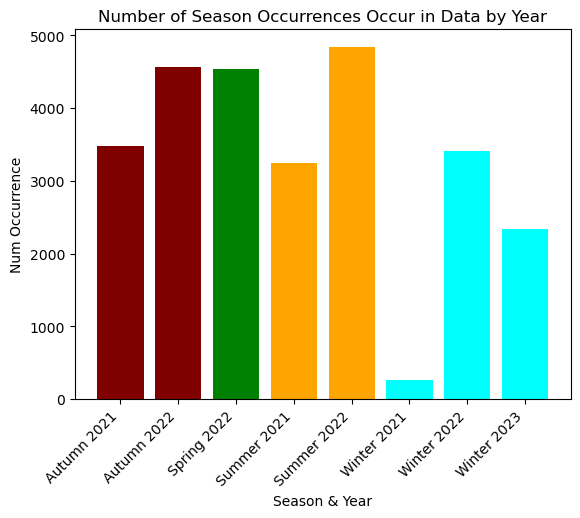

In [109]:
season_year = data_copy_2.groupby(['season', 'year'])

season_count = season_year.agg(Count =('season', 'count'))

display(season_count)
# Confirmed that this matches to the sum of all data entries
print("Total number of rows in the table above is", sum(season_count["Count"]))

# Using mathplotlib graphing on a Pandas dataframe
bars = ('Autumn 2021', 'Autumn 2022', 'Spring 2022', 'Summer 2021', 'Summer 2022', 'Winter 2021', 'Winter 2022', 'Winter 2023')
x_pos = np.arange(len(season_count["Count"]))
plt.bar(x_pos, season_count["Count"], color=['maroon', 'maroon', 'green', 'orange', 'orange', 'cyan', 'cyan', 'cyan'])
plt.xticks(x_pos, bars, rotation = 45, ha = 'right')

plt.xlabel("Season & Year")
plt.ylabel("Num Occurrence") 
  
# displaying the title
plt.title("Number of Season Occurrences Occur in Data by Year")

plt.show()

# Note: As mentioned in an earlier cell, there is no significant difference in the number of days in each season
# as defined by solstices & equinoxes. Winter & Autumn have 88 days, Spring has 92 days, and Summer 93 days.

,Count
season,
autumn,8035
spring,4529
summer,8081
winter,6016


Total number of rows in the table above is 26661


[Text(0.5, 0, 'Season'), Text(0, 0.5, 'Num Occurrence')]

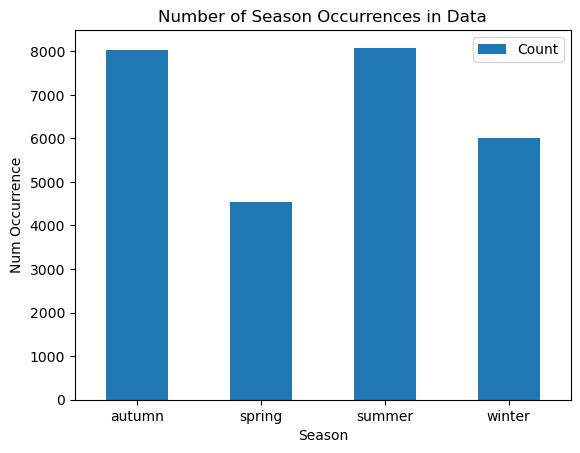

In [19]:
# Conducting through pandas plot function
season = data_copy_2.groupby(['season'])

season_total_count = season.agg(Count =('season', 'count'))

display(season_total_count)
# Confirmed that this matches to the sum of all data entries
print("Total number of rows in the table above is", sum(season_total_count["Count"]))

graphic1 = season_total_count.plot(y="Count", kind="bar", title = "Number of Season Occurrences in Data", rot=0)
graphic1.set(xlabel="Season", ylabel="Num Occurrence")

# Results reconfirm that if focusing on all general phone data, our results will contain more information from autumn & summer

,Count
season,
autumn,5361
spring,3055
summer,5418
winter,4045


Total number of rows in the apple season table above is 17879


[Text(0.5, 0, 'Season'), Text(0, 0.5, 'Num Occurrence')]

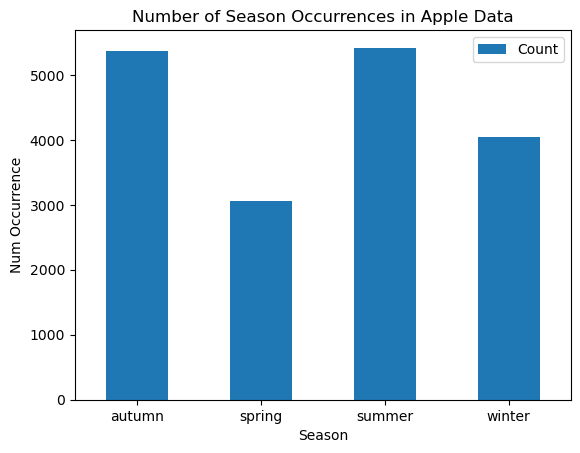

In [20]:
# Check if seasons are skewed for Apple iPhones
# Conducting through pandas plot function
apple_season = apple.groupby(['season'])

apple_season_count = apple_season.agg(Count =('season', 'count'))

display(apple_season_count)
print("Total number of rows in the apple season table above is", sum(apple_season_count["Count"]))

apple_graphic1 = apple_season_count.plot(y="Count", kind="bar", title = "Number of Season Occurrences in Apple Data", rot=0)
apple_graphic1.set(xlabel="Season", ylabel="Num Occurrence")

# Results confirm that our data is skewed to where we will have more Apple data in autumn & summer, which has nothing
# to do with exact phone claims. It wouldn't be skewed if the graphic shows that it's balanced across all 4 seasons.

season
autumn    351418
spring    154457
summer    328015
winter    223866
Name: claim, dtype: int64


Text(0.5, 1.0, 'Number of Total Claims by Season')

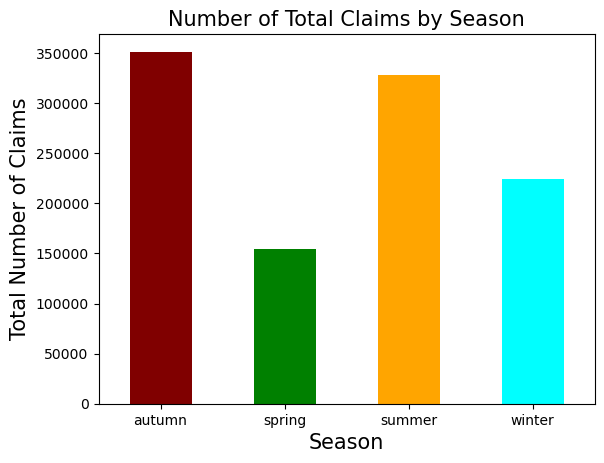

In [21]:
total_claims_season = data_copy_2['claim'].groupby(data_copy['season'])

# Showing the exact claim numbers by season
print(total_claims_season.sum())

claim_season = total_claims_season.sum()

claim_season.plot.bar(x="season", y="claim", color = ['maroon', 'green', 'orange', 'cyan'], rot=0)
plt.xlabel("Season",  size = 15)
plt.ylabel("Total Number of Claims", size = 15)
plt.title("Number of Total Claims by Season", size = 15)

Sum
season year        
autumn 2021  148923
       2022  202495
spring 2022  154457
summer 2021  138291
       2022  189724
winter 2021   10427
       2022  118405
       2023   95034

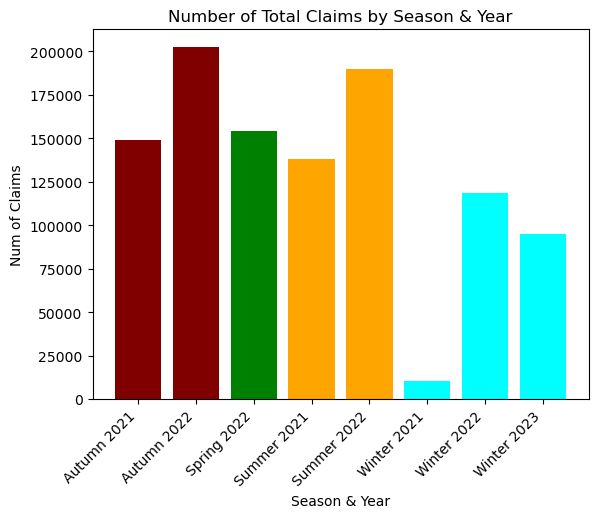

In [39]:
season_year = data_copy_2.groupby(['season', 'year'])

season_year_claim = season_year.agg(Sum =('claim', np.sum))
# Showing the exact claim numbers by season by year
display(season_year_claim)

# Using mathplotlib graphing on a Pandas dataframe
bars = ('Autumn 2021', 'Autumn 2022', 'Spring 2022', 'Summer 2021', 'Summer 2022', 'Winter 2021', 'Winter 2022', 'Winter 2023')
x_pos = np.arange(len(season_year_claim["Sum"]))
plt.bar(x_pos, season_year_claim["Sum"], color=['maroon', 'maroon', 'green', 'orange', 'orange', 'cyan', 'cyan', 'cyan'])
plt.xticks(x_pos, bars, rotation = 45, ha = 'right')

plt.xlabel("Season & Year")
plt.ylabel("Num of Claims") 
  
# displaying the title
plt.title("Number of Total Claims by Season & Year")

plt.show()

season
autumn    267390
spring    115096
summer    253238
winter    168391
Name: claim, dtype: int64


Text(0.5, 1.0, 'Number of Total Apple Claims by Season')

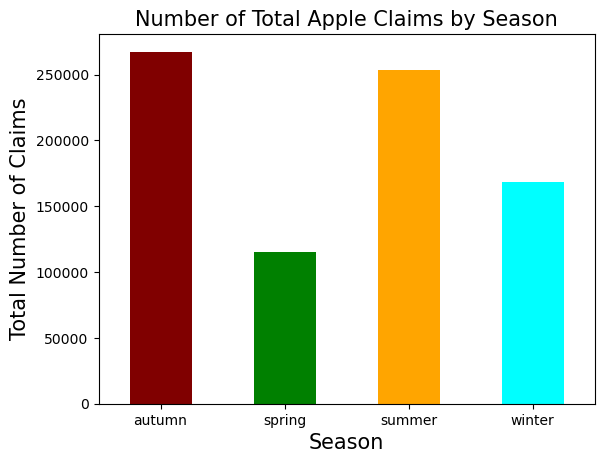

In [23]:
apple_total_claims_season = apple['claim'].groupby(data_copy['season'])

# Showing the exact claim numbers by season for Apple iPhones
print(apple_total_claims_season.sum())

apple_claim_season = apple_total_claims_season.sum()

apple_claim_season.plot.bar(x="season", y="claim", color = ['maroon', 'green', 'orange', 'cyan'], rot=0)
plt.xlabel("Season",  size = 15)
plt.ylabel("Total Number of Claims", size = 15)
plt.title("Number of Total Apple Claims by Season", size = 15)

Sum
season year        
autumn 2021  114584
       2022  152806
spring 2022  115096
summer 2021  108133
       2022  145105
winter 2021    7943
       2022   88887
       2023   71561

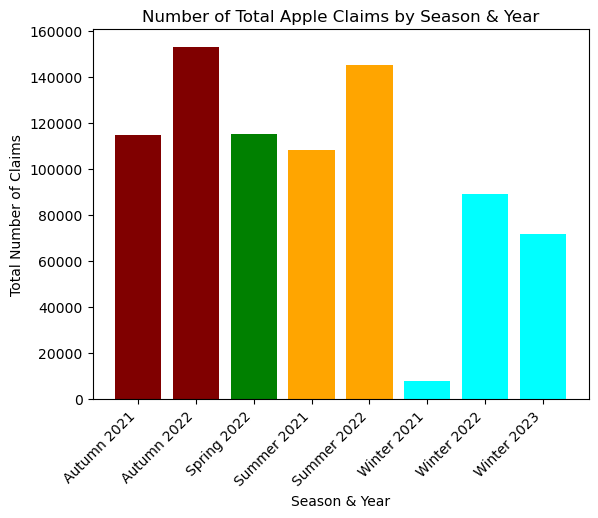

In [77]:
apple_season_year = apple.groupby(['season', 'year'])

apple_season_year_claim = apple_season_year.agg(Sum =('claim', np.sum))
# Showing the exact claim numbers by season by year for Apple iPhones
display(apple_season_year_claim)

# Using mathplotlib graphing on a Pandas dataframe
bars = ('Autumn 2021', 'Autumn 2022', 'Spring 2022', 'Summer 2021', 'Summer 2022', 'Winter 2021', 'Winter 2022', 'Winter 2023')
x_pos = np.arange(len(apple_season_year_claim["Sum"]))
plt.bar(x_pos, apple_season_year_claim["Sum"], color=['maroon', 'maroon', 'green', 'orange', 'orange', 'cyan', 'cyan', 'cyan'])
plt.xticks(x_pos, bars, rotation = 45, ha = 'right')

plt.xlabel("Season & Year")
plt.ylabel("Total Number of Claims") 
  
# displaying the title
plt.title("Number of Total Apple Claims by Season & Year")

plt.show()

Text(0.5, 1.0, 'Apple Claims by Season')

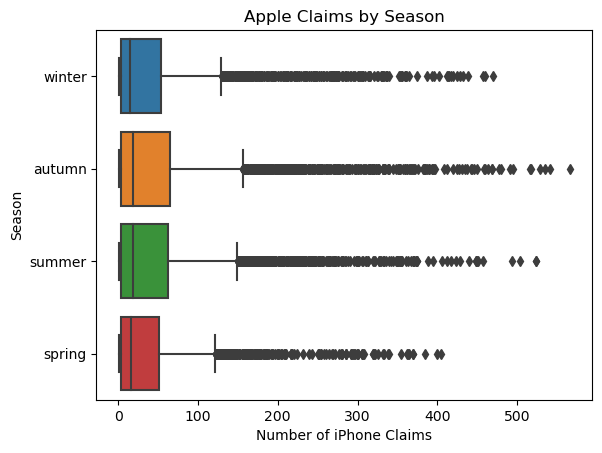

In [27]:
# Boxplot from seaborn
sns.boxplot(data=apple, x="claim", y="season")

plt.xlabel("Number of iPhone Claims") 
plt.ylabel("Season")  

plt.title("Apple Claims by Season")

# Note: It would probably be beneficial if explore how the claims are broken down by season and model as the graphic below
# doesn't show how does model play into an effect, which can impact this graphic's true meaning

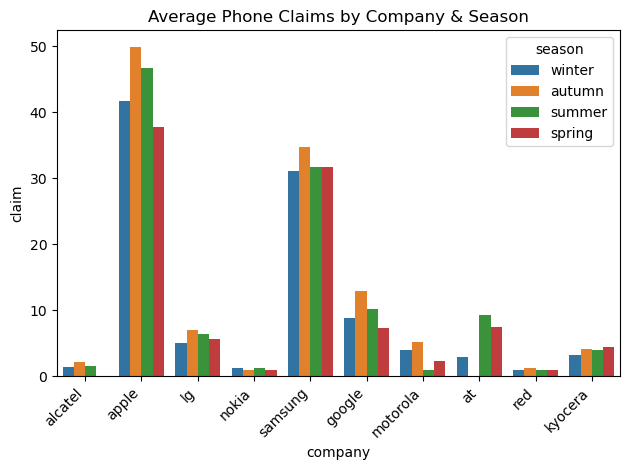

In [53]:
# Graphic shows what's the average number of phone claims for each company by season
# This is a seaborn barplot
sns.barplot(x='company', y='claim', hue='season', data=data_copy_2, ci=None).set(title='Average Phone Claims by Company & Season')
plt.xticks(rotation = 45, ha = 'right')
# Use tight_layout() so the wording doesn't appear, make sure it is after xticks
plt.tight_layout()


## Quarter - EDA

Count
quarter year       
Q1      2022   3691
        2023   2340
Q2      2021    238
        2022   4299
Q3      2021   3257
        2022   4875
Q4      2021   3494
        2022   4467

Total number of rows in the table above is 26661


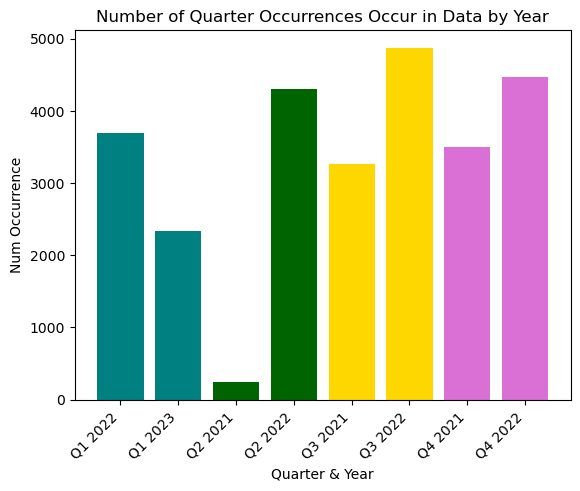

In [106]:
quarter_year = data_copy_2.groupby(['quarter', 'year'])

quarter_count = quarter_year.agg(Count =('quarter', 'count'))

display(quarter_count)

# Confirmed that this matches to the sum of all data entries
print("Total number of rows in the table above is", sum(quarter_count["Count"]))


# Using mathplotlib graphing on a Pandas dataframe
bars = ('Q1 2022', 'Q1 2023', 'Q2 2021', 'Q2 2022', 'Q3 2021', 'Q3 2022', 'Q4 2021', 'Q4 2022')
x_pos = np.arange(len(quarter_count["Count"]))
plt.bar(x_pos, quarter_count["Count"], color=['teal', 'teal', 'darkgreen', 'darkgreen', 'gold', 'gold', 'orchid', 'orchid'])
plt.xticks(x_pos, bars, rotation = 45, ha = 'right')

plt.xlabel("Quarter & Year")
plt.ylabel("Num Occurrence") 
  
# displaying the title
plt.title("Number of Quarter Occurrences Occur in Data by Year")

plt.show()

# Note that we are still in Q1 2023 and data started in 6/28/2021, which is the very last week of Q2 2021

,Count
quarter,
Q1,6031
Q2,4537
Q3,8132
Q4,7961


Total number of rows in the table above is 26661


[Text(0.5, 0, 'Quarter'), Text(0, 0.5, 'Num Occurrence')]

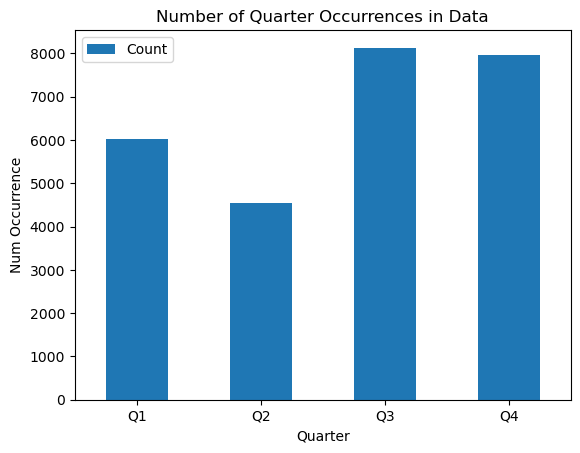

In [32]:
# Conducting through pandas plot function
quarter = data_copy_2.groupby(['quarter'])

quarter_total_count = quarter.agg(Count =('quarter', 'count'))

display(quarter_total_count)
# Confirmed that this matches to the sum of all data entries
print("Total number of rows in the table above is", sum(quarter_total_count["Count"]))

graphic1_quarter = quarter_total_count.plot(y="Count", kind="bar", title = "Number of Quarter Occurrences in Data", rot=0)
graphic1_quarter.set(xlabel="Quarter", ylabel="Num Occurrence")

# Results confirm if focus on all general phone data, our results will contain more information on Q3 and Q4

,Count
quarter,
Q1,4038
Q2,3076
Q3,5431
Q4,5334


Total number of rows in the apple quarter table above is 17879


[Text(0.5, 0, 'Quarter'), Text(0, 0.5, 'Num Occurrence')]

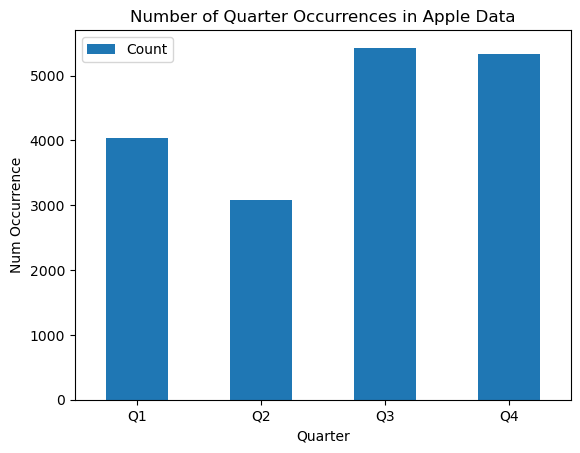

In [34]:
# Check if quarters are skewed for Apple iPhones
# Conducting through pandas plot function
apple_quarter = apple.groupby(['quarter'])

apple_quarter_count = apple_quarter.agg(Count =('quarter', 'count'))

display(apple_quarter_count)
print("Total number of rows in the apple quarter table above is", sum(apple_quarter_count["Count"]))

apple_graphic1_quarter = apple_quarter_count.plot(y="Count", kind="bar", title = "Number of Quarter Occurrences in Apple Data", rot=0)
apple_graphic1_quarter.set(xlabel="Quarter", ylabel="Num Occurrence")

# Results confirm that our data is skewed to where we will have more Apple data in Q3 & Q4, which has nothing
# to do with exact phone claims. It wouldn't be skewed if the graphic shows that it's balanced across all 4 quarters.

quarter
Q1    220619
Q2    150074
Q3    337233
Q4    349830
Name: claim, dtype: int64


Text(0.5, 1.0, 'Number of Total Claims by Quarter')

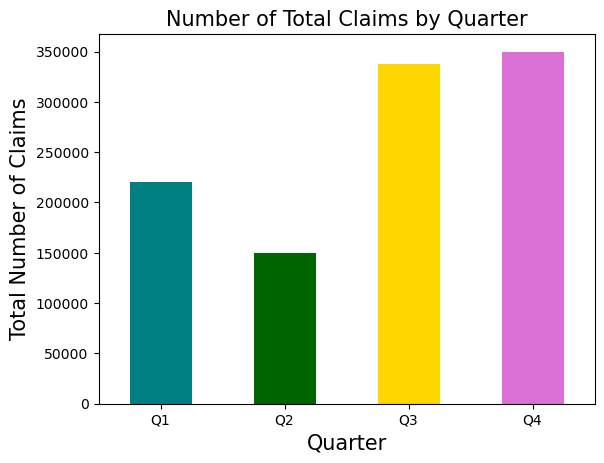

In [36]:
total_claims_quarter = data_copy_2['claim'].groupby(data_copy['quarter'])

# Showing the exact claim numbers by quarter
print(total_claims_quarter.sum())

claim_quarter = total_claims_quarter.sum()

claim_quarter.plot.bar(x="quarter", y="claim", color = ['teal', 'darkgreen', 'gold', 'orchid'], rot=0)
plt.xlabel("Quarter",  size = 15)
plt.ylabel("Total Number of Claims", size = 15)
plt.title("Number of Total Claims by Quarter", size = 15)


Sum
quarter year        
Q1      2022  125585
        2023   95034
Q2      2021    4786
        2022  145288
Q3      2021  145276
        2022  191957
Q4      2021  147579
        2022  202251

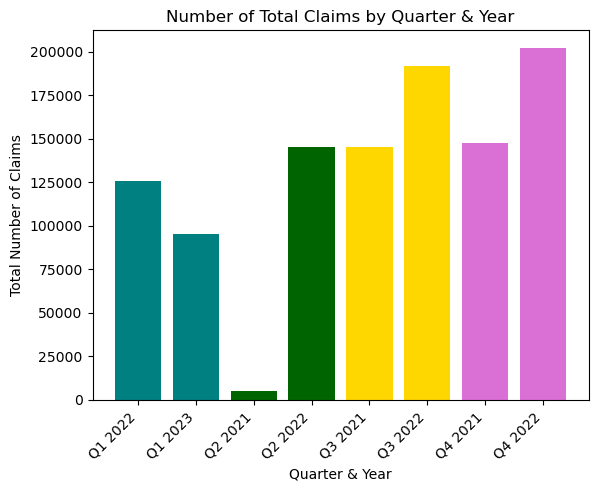

In [78]:
quarter_year = data_copy_2.groupby(['quarter', 'year'])

quarter_year_claim = quarter_year.agg(Sum =('claim', np.sum))
# Showing the exact claim numbers by quarter by year
display(quarter_year_claim)

# Using mathplotlib graphing on a Pandas dataframe
bars = ('Q1 2022', 'Q1 2023', 'Q2 2021', 'Q2 2022', 'Q3 2021', 'Q3 2022', 'Q4 2021', 'Q4 2022')
x_pos = np.arange(len(quarter_year_claim["Sum"]))
plt.bar(x_pos, quarter_year_claim["Sum"], color=['teal', 'teal', 'darkgreen', 'darkgreen', 'gold', 'gold', 'orchid', 'orchid'])
plt.xticks(x_pos, bars, rotation = 45, ha = 'right')

plt.xlabel("Quarter & Year")
plt.ylabel("Total Number of Claims") 
  
# displaying the title
plt.title("Number of Total Claims by Quarter & Year")

plt.show()

# Note data started on 6/28/2021, which was the end of Q2 2021 and we are still ongoing in Q1 2023

quarter
Q1    165435
Q2    112224
Q3    259933
Q4    266523
Name: claim, dtype: int64


Text(0.5, 1.0, 'Number of Total Apple Claims by Quarter')

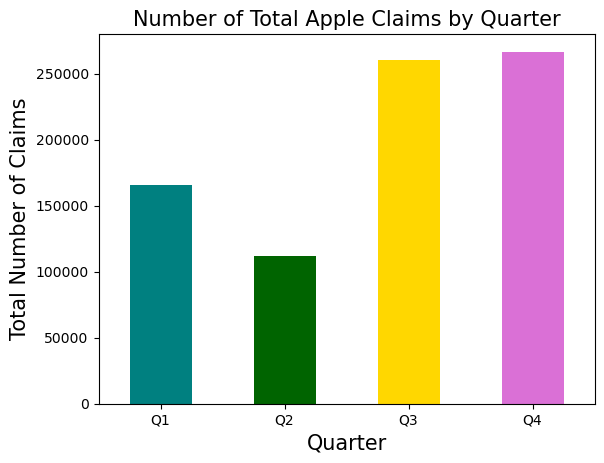

In [42]:
apple_total_claims_quarter = apple['claim'].groupby(data_copy['quarter'])

# Showing the exact claim numbers by quarter
print(apple_total_claims_quarter.sum())

apple_claim_quarter = apple_total_claims_quarter.sum()

apple_claim_quarter.plot.bar(x="Quarter", y="claim", color = ['teal', 'darkgreen', 'gold', 'orchid'], rot=0)
plt.xlabel("Quarter",  size = 15)
plt.ylabel("Total Number of Claims", size = 15)
plt.title("Number of Total Apple Claims by Quarter", size = 15)

Sum
quarter year        
Q1      2022   93874
        2023   71561
Q2      2021    3776
        2022  108448
Q3      2021  113377
        2022  146556
Q4      2021  113507
        2022  153016

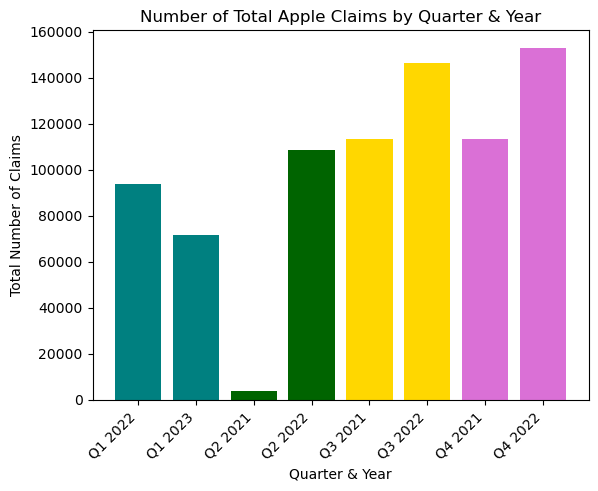

In [79]:
apple_quarter_year = apple.groupby(['quarter', 'year'])

apple_quarter_year_claim = apple_quarter_year.agg(Sum =('claim', np.sum))
# Showing the exact claim numbers by quarter by year for Apple iPhones
display(apple_quarter_year_claim)

# Using mathplotlib graphing on a Pandas dataframe
bars = ('Q1 2022', 'Q1 2023', 'Q2 2021', 'Q2 2022', 'Q3 2021', 'Q3 2022', 'Q4 2021', 'Q4 2022')
x_pos = np.arange(len(apple_quarter_year_claim["Sum"]))
plt.bar(x_pos, apple_quarter_year_claim["Sum"], color=['teal', 'teal', 'darkgreen', 'darkgreen', 'gold', 'gold', 'orchid', 'orchid'])
plt.xticks(x_pos, bars, rotation = 45, ha = 'right')

plt.xlabel("Quarter & Year")
plt.ylabel("Total Number of Claims") 
  
# displaying the title
plt.title("Number of Total Apple Claims by Quarter & Year")

plt.show()

Text(0.5, 1.0, 'Apple Claims by Quarter')

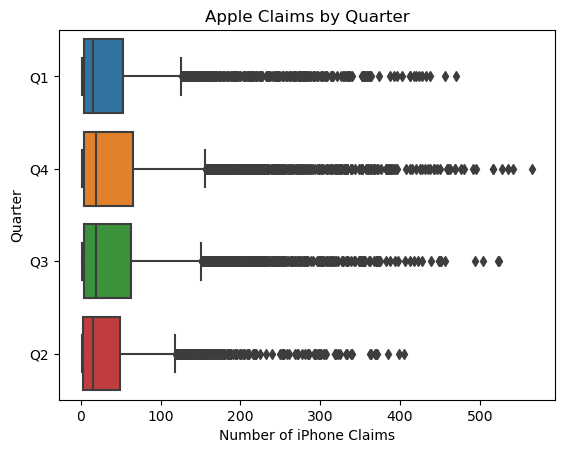

In [46]:
# Boxplot from seaborn
sns.boxplot(data=apple, x="claim", y="quarter")

plt.xlabel("Number of iPhone Claims") 
plt.ylabel("Quarter")  

plt.title("Apple Claims by Quarter")

# Note: It would probably be beneficial if explore how the claims are broken down by quarter and model as the graphic below
# doesn't show how does model play into an effect, which can impact this graphic's true meaning

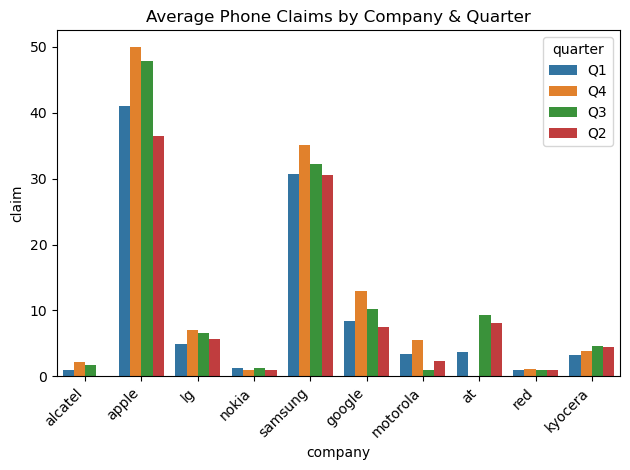

In [54]:
# Graphic shows what's the average number of phone claims for each company by quarter
# This is a seaborn barplot

sns.barplot(x='company', y='claim', hue='quarter', data=data_copy_2, ci=None).set(title='Average Phone Claims by Company & Quarter')
plt.xticks(rotation = 45, ha = 'right')
# Use tight_layout() so the wording doesn't appear, make sure it is after xticks
plt.tight_layout()

## Holidays - EDA

In [110]:
holidays = data_copy_2.groupby(['Holidays_Boolean'])

holidays_count = holidays.agg(Count =('Holidays_Boolean', 'count'))

# Counting how many rows in the data fall into which holiday bucket
display(holidays_count)

print("The percentage of rows that do not have holiday is", round(20814/26661*100,2) , "%")
print("The percentage of rows that have holiday is", round(5847/26661*100,2) , "%")

,Count
Holidays_Boolean,
False,20814
True,5847


The percentage of rows that do not have holiday is 78.07 %
The percentage of rows that have holiday is 21.93 %


,Sum
Holidays_Boolean,
False,818386
True,239370


The percentage of claims that happen when it is not a holiday is 77.37 %
The percentage of claims that happen when it is a holiday is 22.63 %


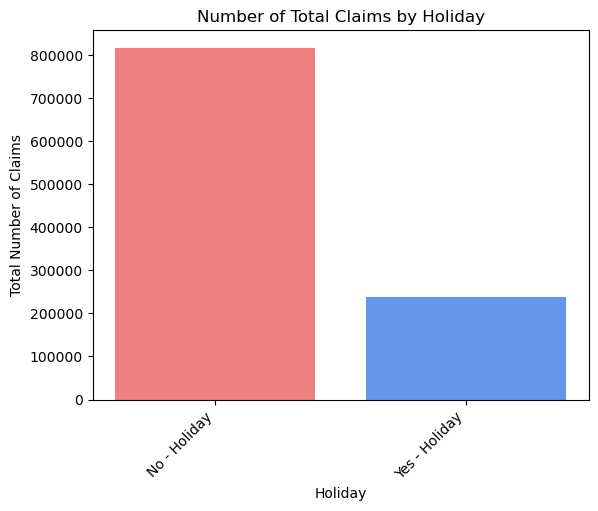

In [81]:
holidays = data_copy_2.groupby(['Holidays_Boolean'])

holidays_claim = holidays.agg(Sum =('claim', np.sum))

# Showing the exact claim numbers by holiday
display(holidays_claim)
print("The percentage of claims that happen when it is not a holiday is", round(818386/1057756*100,2) , "%")
print("The percentage of claims that happen when it is a holiday is", round(239370/1057756*100,2) , "%")

# Using mathplotlib graphing on a Pandas dataframe
bars = ('No - Holiday', 'Yes - Holiday')
x_pos = np.arange(len(holidays_claim["Sum"]))
plt.bar(x_pos, holidays_claim["Sum"], color=['lightcoral', 'cornflowerblue'])
plt.xticks(x_pos, bars, rotation = 45, ha = 'right')

plt.xlabel("Holiday")
plt.ylabel("Total Number of Claims") 
  
# displaying the title
plt.title("Number of Total Claims by Holiday")

plt.show()

# Based on the percentage of holidays available in the dataset, there doesn't seem to be much of a significant difference

In [72]:
apple_holidays = apple.groupby(['Holidays_Boolean'])

apple_holidays_count = apple_holidays.agg(Count =('Holidays_Boolean', 'count'))

# Counting how many rows in the data fall into which holiday bucket
display(apple_holidays_count)

print("The percentage of Apple rows that do not have holiday is", round(13971/17879*100,2) , "%")
print("The percentage of Apple rows that have holiday is", round(3908/17879*100,2) , "%")

,Count
Holidays_Boolean,
False,13971
True,3908


The percentage of Apple rows that do not have holiday is 78.14 %
The percentage of Apple rows that have holiday is 21.86 %


,Sum
Holidays_Boolean,
False,622165
True,181950


The percentage of Apple claims that happen when it is not a holiday is 77.37 %
The percentage of Apple claims that happen when it is a holiday is 22.63 %


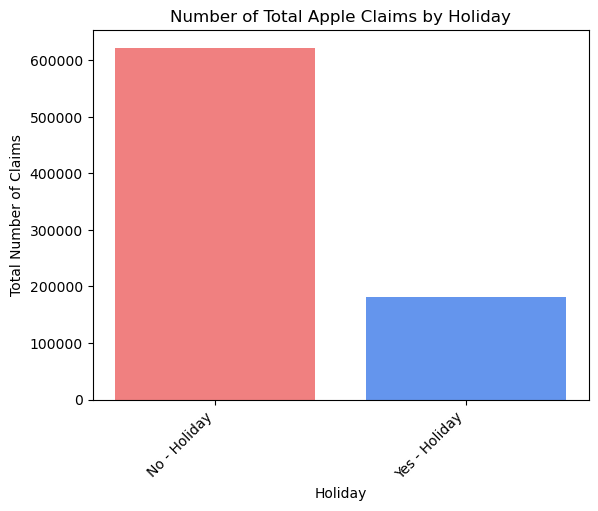

In [83]:
apple_holidays = apple.groupby(['Holidays_Boolean'])

apple_holidays_claim = apple_holidays.agg(Sum =('claim', np.sum))

# Showing the exact claim numbers by holiday
display(apple_holidays_claim)
print("The percentage of Apple claims that happen when it is not a holiday is", round(622165/804115*100,2) , "%")
print("The percentage of Apple claims that happen when it is a holiday is", round(181950/804115*100,2) , "%")

# Using mathplotlib graphing on a Pandas dataframe
bars = ('No - Holiday', 'Yes - Holiday')
x_pos = np.arange(len(apple_holidays_claim["Sum"]))
plt.bar(x_pos, apple_holidays_claim["Sum"], color=['lightcoral', 'cornflowerblue'])
plt.xticks(x_pos, bars, rotation = 45, ha = 'right')

plt.xlabel("Holiday")
plt.ylabel("Total Number of Claims") 
  
# displaying the title
plt.title("Number of Total Apple Claims by Holiday")

plt.show()

# Based on the percentage of holidays available in the dataset, there doesn't seem to be much of a significant difference
# Percentages match-up when doing the comparison on all general phones

Text(0.5, 1.0, 'Apple Claims by Holiday')

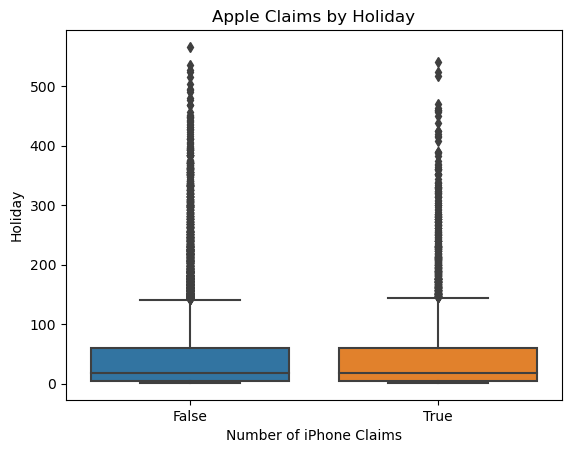

In [88]:
# Boxplot from seaborn
sns.boxplot(data = apple, x="Holidays_Boolean", y="claim")

plt.xlabel("Number of iPhone Claims") 
plt.ylabel("Holiday")  

plt.title("Apple Claims by Holiday")

# Note: It would probably be beneficial if explore how the claims are broken down by season and model as the graphic below
# doesn't show how does model play into an effect, which can impact this graphic's true meaning

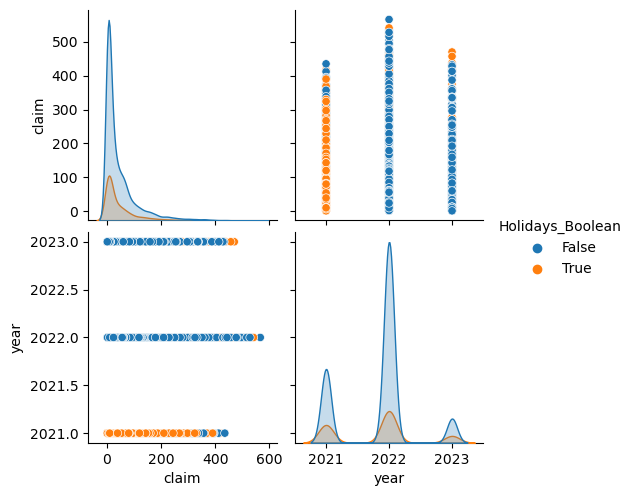

In [89]:
sns.pairplot(apple, hue="Holidays_Boolean")

Text(0, 0.5, 'Total Number of iPhone Claims')

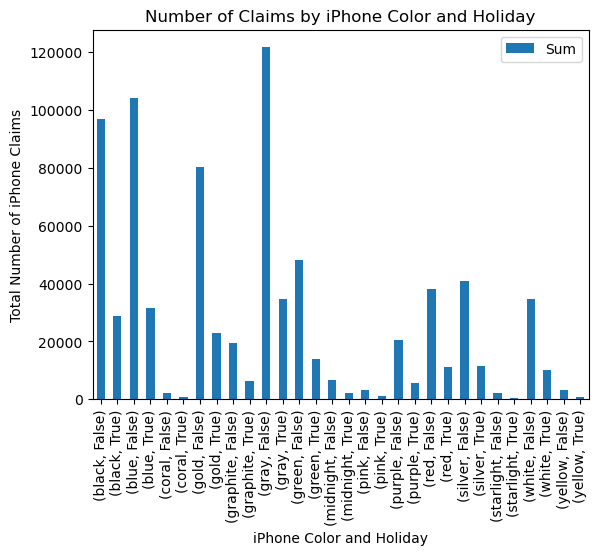

In [105]:
apple_color_holiday = apple.groupby(['phone color', 'Holidays_Boolean'])

# Shows the number of claims for each iPhone color within holiday category
apple_color_holiday_sum = apple_color_holiday.agg(Sum =('claim',np.sum))

#display(apple_color_holiday_sum)

apple_color_holiday_sum.plot(y="Sum", kind="bar", title = "Number of Claims by iPhone Color and Holiday")

plt.xlabel("iPhone Color and Holiday") 
plt.ylabel("Total Number of iPhone Claims") 
